In [ ]:
import pandas as pd

df = pd.read_csv ('../data/cleaned_online_retail.csv')
print (df)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406829 entries, 0 to 406828
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   406829 non-null  int64  
 1   invoiceno    406829 non-null  object 
 2   stockcode    406829 non-null  object 
 3   description  406829 non-null  object 
 4   quantity     406829 non-null  int64  
 5   invoicedate  406829 non-null  object 
 6   unitprice    406829 non-null  float64
 7   customerid   406829 non-null  float64
 8   country      406829 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 27.9+ MB


In [3]:
print(df.columns)

Index(['Unnamed: 0', 'invoiceno', 'stockcode', 'description', 'quantity',
       'invoicedate', 'unitprice', 'customerid', 'country'],
      dtype='object')


In [4]:
#Dropping unnecessary columns
df.drop(['Unnamed: 0'], axis=1, inplace=True)
print(df.columns)

Index(['invoiceno', 'stockcode', 'description', 'quantity', 'invoicedate',
       'unitprice', 'customerid', 'country'],
      dtype='object')


In [5]:
#Extracting year and month from invoicedate

df['year'] = pd.DatetimeIndex(df['invoicedate']).year
df['month'] = pd.DatetimeIndex(df['invoicedate']).month

In [6]:
df.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,year,month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01T08:26:00,2.55,17850.0,United Kingdom,2010,12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01T08:26:00,3.39,17850.0,United Kingdom,2010,12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01T08:26:00,2.75,17850.0,United Kingdom,2010,12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01T08:26:00,3.39,17850.0,United Kingdom,2010,12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01T08:26:00,3.39,17850.0,United Kingdom,2010,12


In [7]:
categorical_features = ['stockcode', 'description', 'country', 'month', 'year']

In [8]:
for column in categorical_features:
  df[column] = df[column].astype('category').cat.codes

In [9]:
print(df)

       invoiceno  stockcode  description  quantity          invoicedate  \
0         536365       3249         3716         6  2010-12-01T08:26:00   
1         536365       2649         3724         6  2010-12-01T08:26:00   
2         536365       2855          861         8  2010-12-01T08:26:00   
3         536365       2803         1813         6  2010-12-01T08:26:00   
4         536365       2802         2776         6  2010-12-01T08:26:00   
...          ...        ...          ...       ...                  ...   
406824    581587       1470         2263        12  2011-12-09T12:50:00   
406825    581587       1746          695         6  2011-12-09T12:50:00   
406826    581587       2086          701         4  2011-12-09T12:50:00   
406827    581587       2087          700         4  2011-12-09T12:50:00   
406828    581587       1039          271         3  2011-12-09T12:50:00   

        unitprice  customerid  country  year  month  
0            2.55     17850.0       35     0 

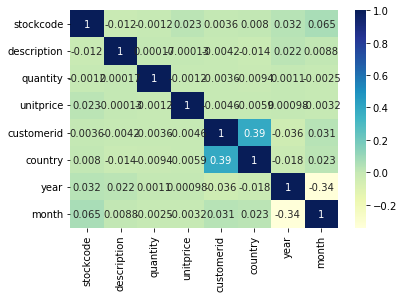

In [13]:
import matplotlib.pyplot as mp
import pandas as pd
import seaborn as sb
corr = df.corr().round(3)
dataplot = sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
mp.show()

In [15]:
import numpy as np
import pandas as pd
from patsy import dmatrices

from statsmodels.compat import lzip
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=14)


In [16]:
# estimate the model and save it as lm (linear model)
lm = ols("quantity ~ month + year", data=df).fit()

In [17]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               quantity   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.263
Date:                Thu, 16 Jun 2022   Prob (F-statistic):              0.283
Time:                        16:13:35   Log-Likelihood:            -2.8214e+06
No. Observations:              406829   AIC:                         5.643e+06
Df Residuals:                  406826   BIC:                         5.643e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.9432      2.021      6.404      0.0

In [ ]:
fig = sm.graphics.influence_plot(lm, criterion="cooks")
fig.tight_layout(pad=1.0)